In [1]:
#move to data/audio folder from ~/notebooks/
%cd ../data/audio

/home/akshay/Desktop/COMP 562/Final Project/generativeMusic/data/audio


In [2]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import numpy as np
import glob
import re
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from random import shuffle


Using TensorFlow backend.


In [40]:
file_list = glob.glob('*.wav')

#build spectrograms for conv net
spectrograms = []
for audio_file in file_list:
    sample_rate, samples = wavfile.read(audio_file)
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
    np.place(spectrogram, spectrogram == 0, 10**-10) #avoid div by 0 for log
    
    audio_raw_name = re.search('.+?(?=\.wav)', audio_file).group(0) #remove .wav extension
    
    with open('../annotations/meter/' + audio_raw_name + '.meter', 'r') as file:
        meter = file.readline()
    
    spectrograms.append([audio_raw_name, np.log(spectrogram), meter])
    
#clean spectrograms data
invalid_songs = [[],[]]
for index, x in enumerate(spectrograms):
    if(x[1].shape != (129, 23624)):
        invalid_songs[0].append(index)
        invalid_songs[1].append(x[0])

for i in sorted(invalid_songs[0], reverse= True):
    del spectrograms[i]




In [4]:
import math

def spec_window(times, spectrogram, window):
    spectrogram_window = np.zeros((spectrogram.shape[0], math.ceil(spectrogram.shape[1]/window)), dtype = 'float32')
    times_window = np.zeros((math.ceil(times.shape[0]/window),), dtype = 'float32')
    for i in range(0, spectrogram.shape[1], window):
        if (i + window < spectrogram.shape[1]):
            spectrogram_window[:,int(i/window)] = np.mean(spectrogram[:, i:i+window], axis= 1)
            times_window[int(i/window)] = np.mean(times[i:i+window])
        else:
            spectrogram_window[:,int(i/window)] = np.mean(spectrogram[:, i:], axis = 1)
            times_window[int(i/window)] = np.mean(times[i:])

    return times_window, spectrogram_window

def spec_plot(times, frequencies, spectrogram, title):
    plt.pcolormesh(times, frequencies, np.log(spectrogram))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(title)
    plt.show()

    

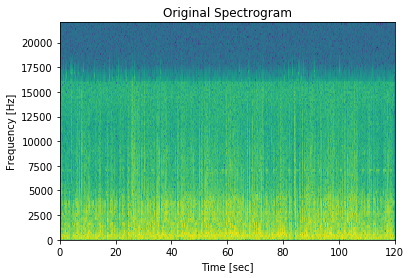

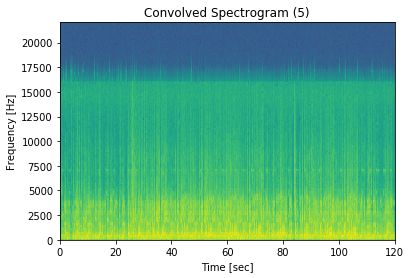

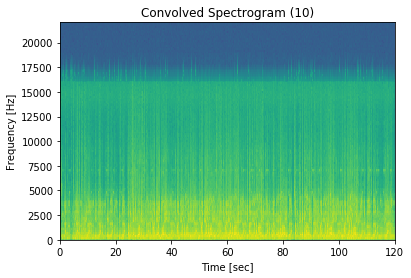

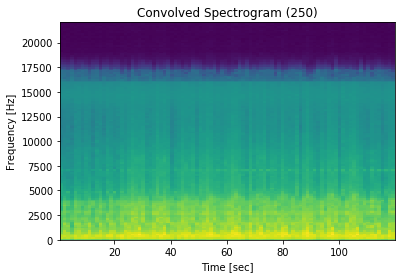

In [16]:
spec_plot(times, frequencies, spectrogram, 'Original Spectrogram')
times_conv, spec_conv = spec_window(times, spectrogram, 5)
spec_plot(times_conv, frequencies, spec_conv, 'Convolved Spectrogram (5)') #convolved probs wrong term
times_conv, spec_conv = spec_window(times, spectrogram, 10)
spec_plot(times_conv, frequencies, spec_conv, 'Convolved Spectrogram (10)')
times_conv, spec_conv = spec_window(times, spectrogram, 250)
spec_plot(times_conv, frequencies, spec_conv, 'Convolved Spectrogram (250)')


In [41]:
import copy
spectrograms_conv = copy.deepcopy(spectrograms) #don't want to change original, deepcopy to copy objs in list
dummy = np.zeros((spectrograms[0][1].shape[1],), dtype = 'float32')
for index, rows in enumerate(spectrograms):
    _, spectrograms_conv[index][1] = spec_window(dummy, rows[1], 150)
    



In [42]:
spectrograms_conv[0][1].shape
#spectrograms[0][1].shape

(129, 158)

In [43]:
len(spectrograms) * .7 #80

def load_data(spec_data):
    
    x_train = np.array([x[1] for x in spec_data[:80]])
    y_train = np.array([x[2] for x in spec_data[:80]])
    
    x_test = np.array([x[1] for x in spec_data[80:]])
    y_test = np.array([x[2] for x in spec_data[80:]])
    
    #print(x_train.shape)
    
    return (x_train, y_train), (x_test, y_test)

shuffle(spectrograms_conv) #shuffle spectrogram data

In [44]:
batch_size = 10
num_classes = 4
epochs = 100

# input image dimensions
img_x, img_y = spectrograms_conv[0][1].shape

# load the spectrogram data
(x_train, y_train), (x_test, y_test) = load_data(spectrograms_conv)

n_train = x_train.shape[0]
n_test = x_test.shape[0]

# convert the data to the right type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = np.reshape(x_train, (n_train*img_x, img_y)) #2D for MinMaxScaler
x_test = np.reshape(x_test, (n_test*img_x, img_y)) #2D for MinMaxScaler


scaler = MinMaxScaler(feature_range = (-1,1))
scaler.fit(x_train)
x_train  = scaler.transform(x_train)
scaler.fit(x_test)
x_test = scaler.transform(x_test)

# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# RGB colour images would have 3, spectrogram data has 1?
x_train = x_train.reshape(n_train, img_x, img_y, 1)
x_test = x_test.reshape(n_test, img_x, img_y, 1)
input_shape = (img_x, img_y, 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print('x_test shape:', x_train.shape)
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below

le = LabelEncoder()
le.fit(y_train)
y_train = keras.utils.to_categorical(le.transform(y_train), num_classes)
y_test = keras.utils.to_categorical(le.transform(y_test), num_classes)

del spectrograms

x_train shape: (80, 129, 158, 1)
80 train samples
x_test shape: (80, 129, 158, 1)
34 test samples


In [46]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(24, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])


class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[history])



Train on 80 samples, validate on 34 samples
Epoch 1/100
80/80 [==============================] - 2s 23ms/step - loss: 1.6700 - acc: 0.2750 - val_loss: 1.3692 - val_acc: 0.2941
Epoch 2/100
80/80 [==============================] - 1s 13ms/step - loss: 1.3835 - acc: 0.3250 - val_loss: 1.3856 - val_acc: 0.3824
Epoch 3/100
80/80 [==============================] - 1s 13ms/step - loss: 1.3822 - acc: 0.4625 - val_loss: 1.3805 - val_acc: 0.3235
Epoch 4/100
80/80 [==============================] - 1s 14ms/step - loss: 1.3623 - acc: 0.4250 - val_loss: 1.3740 - val_acc: 0.2941
Epoch 5/100
80/80 [==============================] - 1s 13ms/step - loss: 1.3146 - acc: 0.5125 - val_loss: 1.3899 - val_acc: 0.2941
Epoch 6/100
80/80 [==============================] - 1s 13ms/step - loss: 1.2071 - acc: 0.5625 - val_loss: 1.3210 - val_acc: 0.4118
Epoch 7/100
80/80 [==============================] - 1s 13ms/step - loss: 1.1590 - acc: 0.5375 - val_loss: 1.4407 - val_acc: 0.3824
Epoch 8/100
80/80 [=============

80/80 [==============================] - 1s 14ms/step - loss: 1.2884e-04 - acc: 1.0000 - val_loss: 3.6923 - val_acc: 0.3235
Epoch 62/100
80/80 [==============================] - 1s 13ms/step - loss: 1.2309e-04 - acc: 1.0000 - val_loss: 3.7076 - val_acc: 0.3235
Epoch 63/100
80/80 [==============================] - 1s 13ms/step - loss: 1.1860e-04 - acc: 1.0000 - val_loss: 3.7593 - val_acc: 0.3235
Epoch 64/100
80/80 [==============================] - 1s 13ms/step - loss: 1.1367e-04 - acc: 1.0000 - val_loss: 3.7114 - val_acc: 0.3235
Epoch 65/100
80/80 [==============================] - 1s 13ms/step - loss: 1.0881e-04 - acc: 1.0000 - val_loss: 3.7587 - val_acc: 0.3235
Epoch 66/100
80/80 [==============================] - 1s 13ms/step - loss: 1.0274e-04 - acc: 1.0000 - val_loss: 3.7912 - val_acc: 0.3235
Epoch 67/100
80/80 [==============================] - 1s 14ms/step - loss: 9.7762e-05 - acc: 1.0000 - val_loss: 3.7419 - val_acc: 0.3235
Epoch 68/100
80/80 [==============================] - 

In [31]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.816825971883886
Test accuracy: 0.20588235294117646


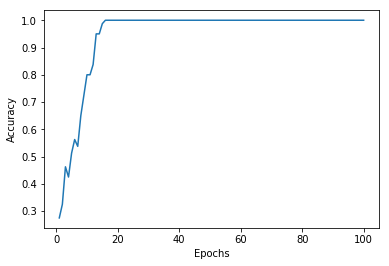

In [48]:
plt.plot(range(1, 101), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [45]:
del model